In [10]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
import zipfile
import os
import dataset, modules

figure_path = "figures/"

# Load data
train, test, validate = dataset.load_data()
data_variance = np.var(train)


In [11]:

# Train VQVAE
vqvae_trainer = modules.VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(train, epochs=200, batch_size=8, steps_per_epoch=len(train)/8)


Epoch 1/200
75/75 [==============================] - 5s 56ms/step - loss: 84.9614 - reconstruction_loss: 0.6606 - vqvae_loss: 83.9997
Epoch 2/200
75/75 [==============================] - 4s 55ms/step - loss: 10.9875 - reconstruction_loss: 0.4341 - vqvae_loss: 10.4324
Epoch 3/200
75/75 [==============================] - 4s 56ms/step - loss: 11.6314 - reconstruction_loss: 0.2856 - vqvae_loss: 11.3299
Epoch 4/200
75/75 [==============================] - 4s 56ms/step - loss: 3.8847 - reconstruction_loss: 0.2893 - vqvae_loss: 3.6260
Epoch 5/200
75/75 [==============================] - 4s 56ms/step - loss: 5.3592 - reconstruction_loss: 0.3193 - vqvae_loss: 5.0457
Epoch 6/200
75/75 [==============================] - 4s 59ms/step - loss: 3.9046 - reconstruction_loss: 0.2350 - vqvae_loss: 3.6274
Epoch 7/200
75/75 [==============================] - 4s 60ms/step - loss: 2.0279 - reconstruction_loss: 0.1492 - vqvae_loss: 1.8701
Epoch 8/200
75/75 [==============================] - 4s 55ms/step - lo

1/1 [==============================] - 0s 21ms/step
tf.Tensor(0.9108543, shape=(), dtype=float32)
tf.Tensor(0.9147386, shape=(), dtype=float32)
tf.Tensor(0.8835347, shape=(), dtype=float32)
tf.Tensor(0.89815116, shape=(), dtype=float32)
tf.Tensor(0.879141, shape=(), dtype=float32)
tf.Tensor(0.89543945, shape=(), dtype=float32)
tf.Tensor(0.8907035, shape=(), dtype=float32)
tf.Tensor(0.8905095, shape=(), dtype=float32)
tf.Tensor(0.80103916, shape=(), dtype=float32)
tf.Tensor(0.89822143, shape=(), dtype=float32)


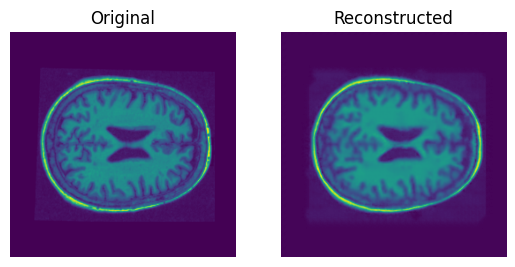

In [42]:

# Plot learning
plt.plot(vqvae_trainer.history.history['reconstruction_loss'], label='reconstruction_loss')
plt.plot(vqvae_trainer.history.history['vqvae_loss'], label = 'vqvae_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.savefig(os.path.join(figure_path, "training_plot"))

# Reconstructions
trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(test), 10)
test_images = test[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

i = 0
for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    filename = os.path.join(figure_path, "reconstruction_" + str(i) + ".png")
    i += 1
    modules.save_subplot(test_image, reconstructed_image, filename)



1/1 [==============================] - 0s 49ms/step


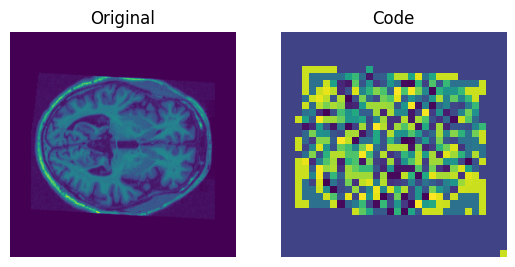

In [13]:

# Encoding
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    filename = os.path.join(figure_path, "codebook_" + str(i) + ".png")
    plt.savefig(filename)


In [14]:
# PixelCNN
num_residual_blocks = 7
num_pixelcnn_layers = 2
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = modules.PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = modules.ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = modules.PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)
pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")

encoded_outputs = encoder.predict(train)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

Input shape of the PixelCNN: (32, 32)
19/19 [==============================] - 0s 23ms/step
Shape of the training data for PixelCNN: (600, 32, 32)


In [43]:
pixel_cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    x=codebook_indices,
    y=codebook_indices,
    batch_size=32,
    epochs=100,
    validation_split=0.1,
)

Epoch 1/100
17/17 [==============================] - 3s 104ms/step - loss: 1.2963 - accuracy: 0.6677 - val_loss: 5.5152 - val_accuracy: 0.5628
Epoch 2/100
17/17 [==============================] - 1s 86ms/step - loss: 0.7753 - accuracy: 0.7528 - val_loss: 6.2714 - val_accuracy: 0.5730
Epoch 3/100
17/17 [==============================] - 1s 86ms/step - loss: 0.5853 - accuracy: 0.8163 - val_loss: 7.9781 - val_accuracy: 0.5740
Epoch 4/100
17/17 [==============================] - 1s 87ms/step - loss: 0.4612 - accuracy: 0.8591 - val_loss: 9.9646 - val_accuracy: 0.5714
Epoch 5/100
17/17 [==============================] - 1s 84ms/step - loss: 0.3819 - accuracy: 0.8856 - val_loss: 12.2197 - val_accuracy: 0.5711
Epoch 6/100
17/17 [==============================] - 1s 84ms/step - loss: 0.3948 - accuracy: 0.8739 - val_loss: 13.8313 - val_accuracy: 0.5708
Epoch 7/100
17/17 [==============================] - 1s 84ms/step - loss: 0.3954 - accuracy: 0.8706 - val_loss: 14.1585 - val_accuracy: 0.5697
Ep

In [44]:
# Create a mini sampler model.
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
outputs = pixel_cnn(inputs, training=False)
categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
sampler = keras.Model(inputs, outputs)

In [45]:
# Create an empty array of priors.
batch = 10
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")

1/1 [==============================] - 0s 50ms/step
Prior shape: (10, 32, 32)


1/1 [==============================] - 0s 18ms/step


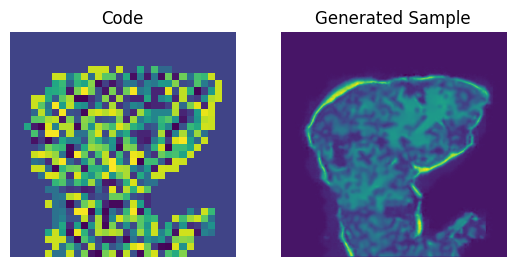

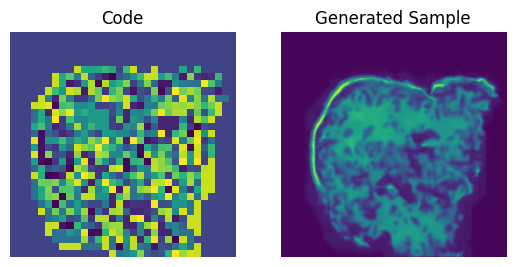

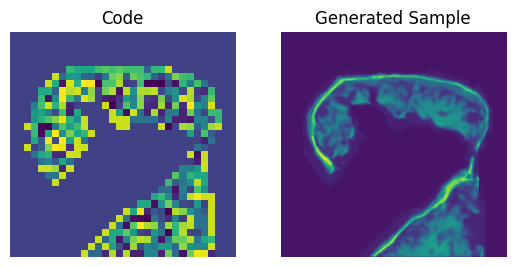

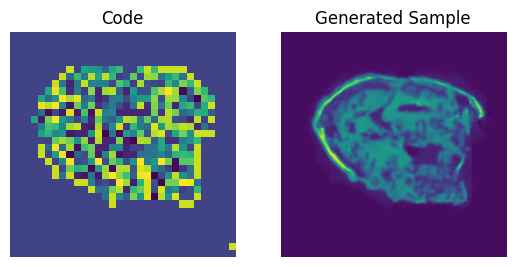

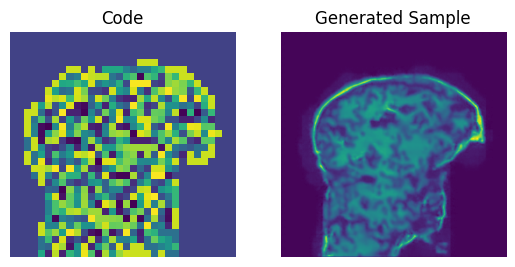

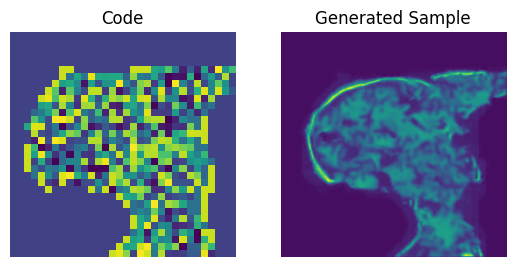

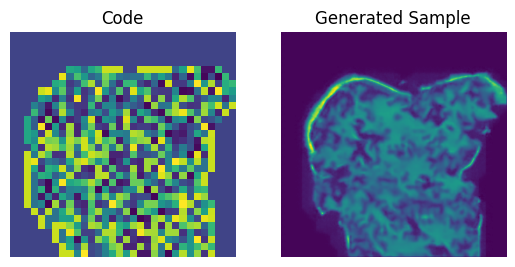

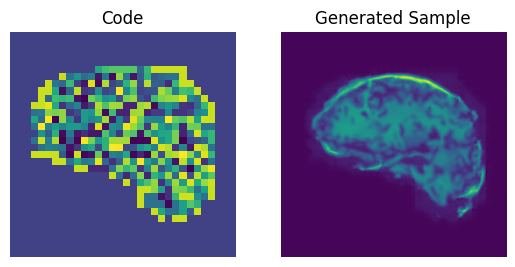

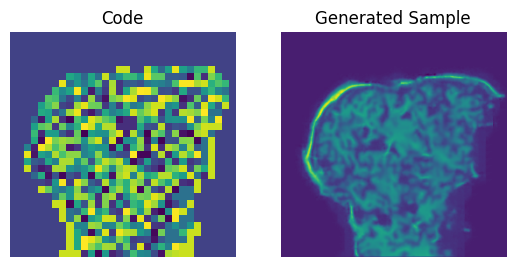

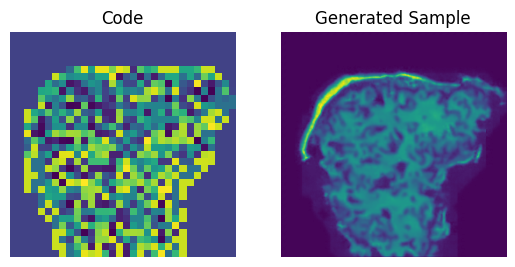

In [46]:
# Perform an embedding lookup.
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()

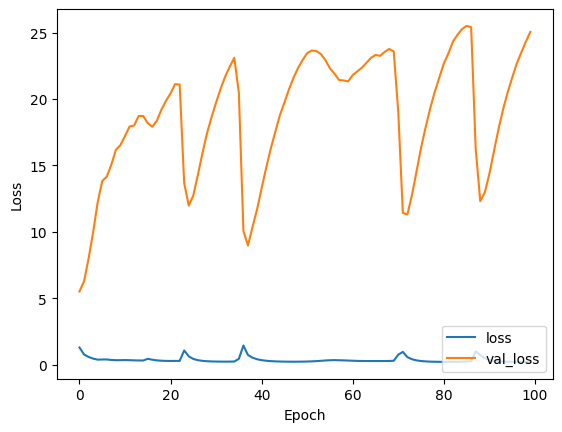

In [47]:
# Plot learning
plt.plot(pixel_cnn.history.history['loss'], label='loss')
plt.plot(pixel_cnn.history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
#plt.savefig(os.path.join(figure_path, "training_plot"))
plt.show()

In [50]:
for i in range(len(generated_samples)):
    img1 = train[i]
    img2 = generated_samples[i]
    print(tf.image.ssim(img1, img2, 1, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03))


tf.Tensor(0.41631326, shape=(), dtype=float32)
tf.Tensor(0.42025906, shape=(), dtype=float32)
tf.Tensor(0.402216, shape=(), dtype=float32)
tf.Tensor(0.5389825, shape=(), dtype=float32)
tf.Tensor(0.45299256, shape=(), dtype=float32)
tf.Tensor(0.45736474, shape=(), dtype=float32)
tf.Tensor(0.3857178, shape=(), dtype=float32)
tf.Tensor(0.54553324, shape=(), dtype=float32)
tf.Tensor(0.44394168, shape=(), dtype=float32)
tf.Tensor(0.40931788, shape=(), dtype=float32)
